# [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic)

## EDA 분석 결과

- Target
  - 이진분류 문제
  - 비율은 5:5 정도임(balanced data)
- Missing Values가 많음
- Continuous
  - Age: 나이대별로 도착 확률이 다름
  - luxury: RoomService, Spa, VRDeck
    - False 데이터인 분들의 소비가 더 높음
  - essential: FoodCourt, ShoppingMall
    - True 데이터인 분들의 소비가 더 높음
- Categorical
  - VIP: 필요없는 데이터임(삭제 필요)
  - CryoSleep: 유용한 데이터일 확률이 높음
  - HomePlanet
  - Destination
- Qualitative
  - PassengerId: group number + people number of group
  - Cabin: deck + number + side
  - Name: first name + last name(성)

## Data

- PassengerId - 각 승객에 대한 고유 ID
  - gggg_pp: gggg는 group, pp는 group에 소속된 사람 수
  - 같은 group에 속한 사람들은 가족일 수도 있고, 아닐 수도 있음
- HomePlanet - 출발 행성(거주지)
- CryoSleep - 취침 방식 여부
- Cabin - 객실 종류 및 번호(port:좌현, starboard: 우현)
- Destination - 목적지
- Age - 승객의 나이
- VIP - 승객의 VIP 서비스 유무
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 해당 서비스에 대한 지불한 금액
- Name - 이름
  - 같은 그룹이면서, 성이 같으면 ?? 가족일 확률이 높음
- Transported - 도착여부

# Global Variables

In [3]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [63]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/spaceship_titanic/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'
args.submission_path = args.default_path+'sample_submission.csv'

args.SEED = 42

# Import Library

In [1]:
!pip install shap
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [2]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 데이터 분리
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
import shap

# model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# warning
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [80]:
import random
import numpy as np

def reset_seeds(seed=args.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)

reset_seeds()

# Load Data

In [5]:
ori_train = pd.read_csv(args.train_path)

print(ori_train.shape)
ori_train.head(3)

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [6]:
ori_test = pd.read_csv(args.test_path)

print(ori_test.shape)

(4277, 13)


In [64]:
pd.read_csv(args.submission_path)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


# Feature Engineering

In [7]:
pre_train = ori_train.copy()
pre_test = ori_test.copy()

pre_train.shape, pre_test.shape

((8693, 14), (4277, 13))

## Missing Values

In [8]:
# Columns with missing values
na_cols=pre_train.columns[pre_train.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(pre_train[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(pre_train),2)

print(mv.shape)
mv

(12, 2)


,Number_missing,Percentage_missing
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11


In [9]:
# Columns with missing values
na_cols=pre_test.columns[pre_test.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(pre_test[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(pre_test),2)

print(mv.shape)
mv

(12, 2)


,Number_missing,Percentage_missing
HomePlanet,87,2.03
CryoSleep,93,2.17
Cabin,100,2.34
Destination,92,2.15
Age,91,2.13
VIP,93,2.17
RoomService,82,1.92
FoodCourt,106,2.48
ShoppingMall,98,2.29
Spa,101,2.36


Text(0.5, 1.0, 'Heatmap of missing values')

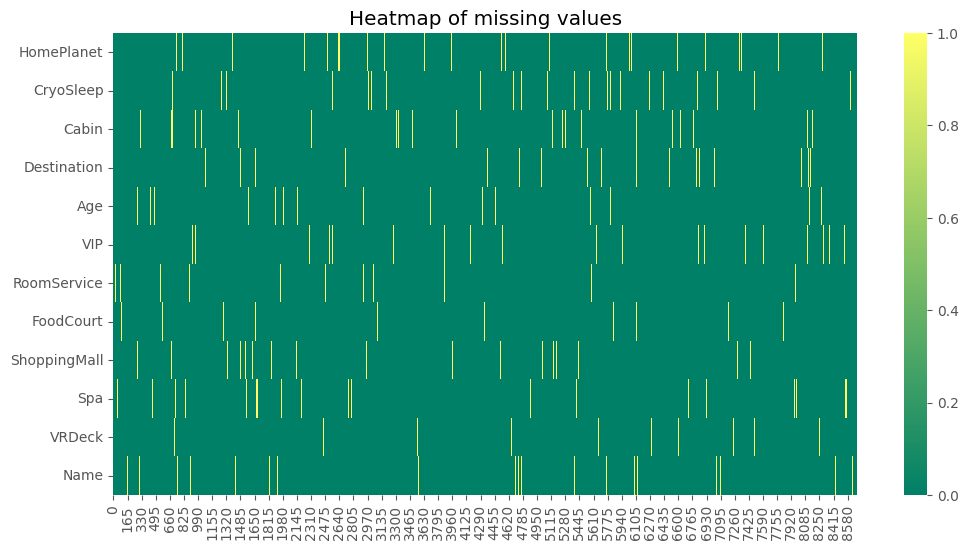

In [10]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(pre_train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

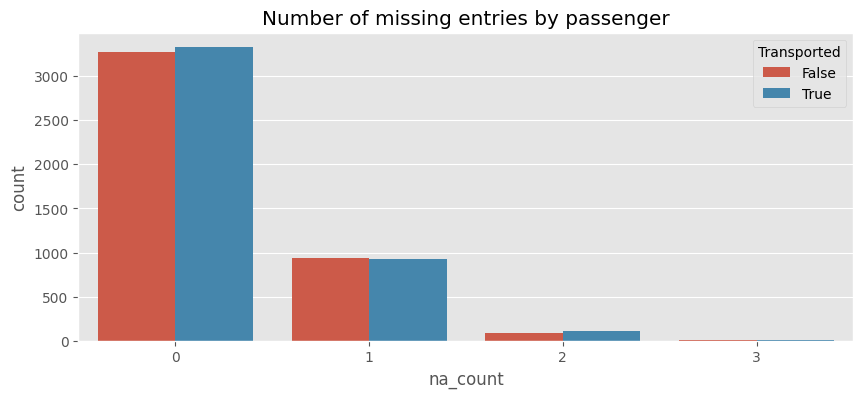

In [11]:
# Countplot of number of missing values by passenger
pre_train['na_count']=pre_train.isna().sum(axis=1)

plt.figure(figsize=(10,4))
sns.countplot(data=pre_train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')

pre_train.drop('na_count', axis=1, inplace=True)

In [12]:
pre_train[na_cols].head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [13]:
pre_train[na_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
dtypes: float64(6), object(6)
memory usage: 815.1+ KB


In [14]:
# Replace NaN's with outliers for now (so we can split feature)
pre_train['Cabin'].fillna('Z/9999/Z', inplace=True)
pre_test['Cabin'].fillna('Z/9999/Z', inplace=True)

In [15]:
# Replace NaN's with outliers for now (so we can split feature)
pre_train['Name'].fillna('Unknown Unknown', inplace=True)
pre_test['Name'].fillna('Unknown Unknown', inplace=True)

In [16]:
pre_train['HomePlanet'] = pre_train['HomePlanet'].fillna(pre_train['HomePlanet'].mode()[0])
pre_train['CryoSleep'] = pre_train['CryoSleep'].fillna(pre_train['CryoSleep'].mode()[0])
pre_train['Destination'] = pre_train['Destination'].fillna(pre_train['Destination'].mode()[0])
pre_train['VIP'] = pre_train['VIP'].fillna(pre_train['VIP'].mode()[0])

pre_test['HomePlanet'] = pre_test['HomePlanet'].fillna(pre_test['HomePlanet'].mode()[0])
pre_test['CryoSleep'] = pre_test['CryoSleep'].fillna(pre_test['CryoSleep'].mode()[0])
pre_test['Destination'] = pre_test['Destination'].fillna(pre_test['Destination'].mode()[0])
pre_test['VIP'] = pre_test['VIP'].fillna(pre_test['VIP'].mode()[0])

In [17]:
pre_train['Age'] = pre_train['Age'].fillna(pre_train['Age'].mean())
pre_train['RoomService'] = pre_train['RoomService'].fillna(pre_train['RoomService'].mean())
pre_train['FoodCourt'] = pre_train['FoodCourt'].fillna(pre_train['FoodCourt'].mean())
pre_train['ShoppingMall'] = pre_train['ShoppingMall'].fillna(pre_train['ShoppingMall'].mean())
pre_train['Spa'] = pre_train['Spa'].fillna(pre_train['Spa'].mean())
pre_train['VRDeck'] = pre_train['VRDeck'].fillna(pre_train['VRDeck'].mean())

pre_test['Age'] = pre_test['Age'].fillna(pre_test['Age'].mean())
pre_test['RoomService'] = pre_test['RoomService'].fillna(pre_test['RoomService'].mean())
pre_test['FoodCourt'] = pre_test['FoodCourt'].fillna(pre_test['FoodCourt'].mean())
pre_test['ShoppingMall'] = pre_test['ShoppingMall'].fillna(pre_test['ShoppingMall'].mean())
pre_test['Spa'] = pre_test['Spa'].fillna(pre_test['Spa'].mean())
pre_test['VRDeck'] = pre_test['VRDeck'].fillna(pre_test['VRDeck'].mean())

In [18]:
pre_train.isnull().sum().sum(), pre_test.isnull().sum().sum()

(0, 0)

## Continous

### Age

Text(0.5, 0, 'Age (years)')

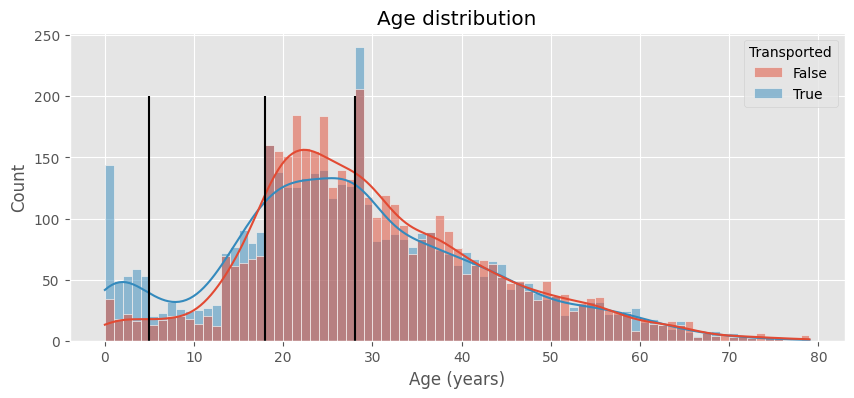

In [19]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=pre_train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.vlines(5, ymin=0, ymax=200, color='black')
plt.vlines(18, ymin=0, ymax=200, color='black')
plt.vlines(28, ymin=0, ymax=200, color='black')

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

- age <= 4
  - True가 압도적으로 많음

In [20]:
pre_train[pre_train['Age'] == 4]['Transported'].value_counts()

True     53
False    18
Name: Transported, dtype: int64

In [21]:
pre_train[pre_train['Age'] == 5 ]['Transported'].value_counts()

True     20
False    13
Name: Transported, dtype: int64

- age <= 17 & age >= 5
  - True가 더 많음

In [22]:
pre_train[pre_train['Age'] == 17 ]['Transported'].value_counts()

True     89
False    69
Name: Transported, dtype: int64

In [23]:
pre_train[pre_train['Age'] == 18 ]['Transported'].value_counts()

True     160
False    160
Name: Transported, dtype: int64

- age <=27 & age >=18
  - False가 더 많음

In [24]:
pre_train[pre_train['Age'] == 27 ]['Transported'].value_counts()

False    132
True     127
Name: Transported, dtype: int64

In [25]:
pre_train[pre_train['Age'] == 28 ]['Transported'].value_counts()

True     150
False    117
Name: Transported, dtype: int64

In [26]:
def add_age_group(age):
    if age <= 4:
      return 'age_4'
    elif age <= 17:
      return 'age_17'
    elif age <= 27:
      return 'age_27'
    else:
      return 'age_28+'

In [27]:
pre_train['age_group'] = pre_train['Age'].map(add_age_group)
pre_test['age_group'] = pre_test['Age'].map(add_age_group)

pre_train[['Age', 'age_group']].head(3)

,Age,age_group
0,39.0,age_28+
1,24.0,age_27
2,58.0,age_28+


In [28]:
pre_train['log_age'] = pre_train['Age'].map(lambda x: np.log1p(x))
pre_test['log_age'] = pre_test['Age'].map(lambda x: np.log1p(x))

pre_train[['Age', 'log_age']].head(3)

,Age,log_age
0,39.0,3.688879
1,24.0,3.218876
2,58.0,4.077537


Text(0.5, 0, 'Age (years)')

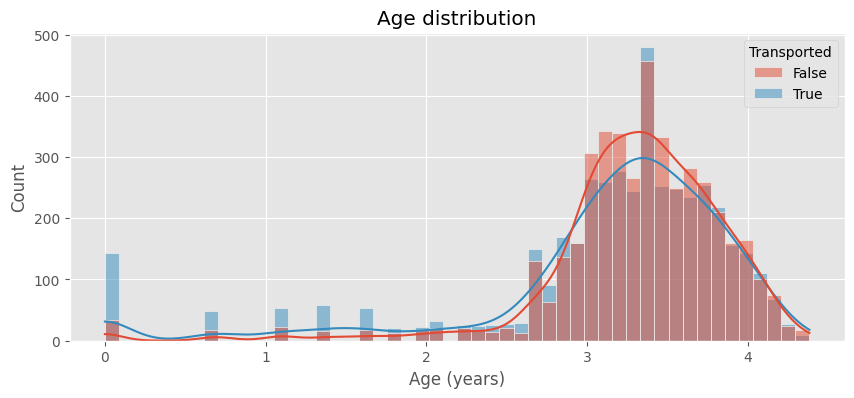

In [29]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=pre_train, x='log_age', hue='Transported', bins=50, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

### luxury
- RoomService, Spa, VRDeck

In [30]:
# New features - training set
luxury_cols = ['RoomService', 'Spa', 'VRDeck']
pre_train['luxury_sum']=pre_train[luxury_cols].sum(axis=1)
pre_train['luxury_no']=(pre_train['luxury_sum']==0).astype(int)

pre_test['luxury_sum']=pre_test[luxury_cols].sum(axis=1)
pre_test['luxury_no']=(pre_test['luxury_sum']==0).astype(int)

pre_train[['RoomService', 'Spa', 'VRDeck', 'luxury_sum', 'luxury_no']].head()

,RoomService,Spa,VRDeck,luxury_sum,luxury_no
0,0.0,0.0,0.0,0.0,1
1,109.0,549.0,44.0,702.0,0
2,43.0,6715.0,49.0,6807.0,0
3,0.0,3329.0,193.0,3522.0,0
4,303.0,565.0,2.0,870.0,0


In [31]:
pre_train['log_luxury'] = pre_train['luxury_sum'].map(lambda x: np.log1p(x))
pre_test['log_luxury'] = pre_test['luxury_sum'].map(lambda x: np.log1p(x))

pre_train[['luxury_sum', 'log_luxury']].head(3)

,luxury_sum,log_luxury
0,0.0,0.000000
1,702.0,6.555357
2,6807.0,8.825854


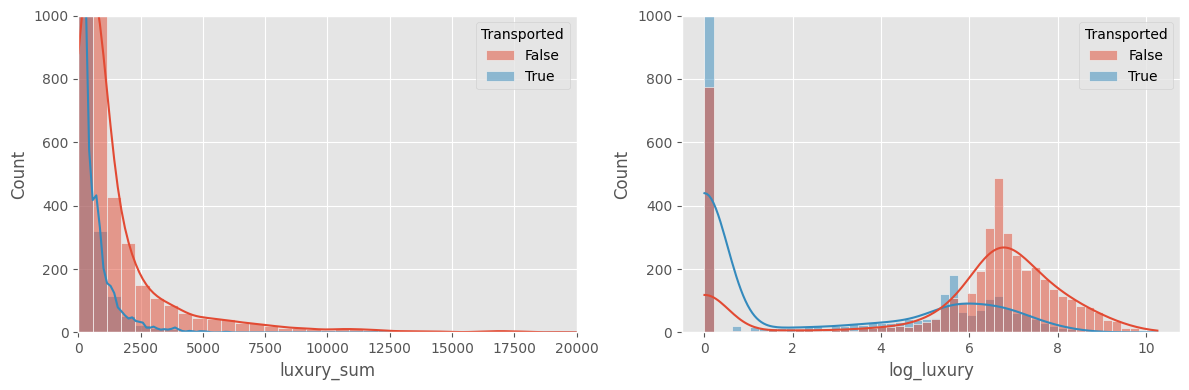

In [32]:
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=pre_train, x='luxury_sum', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.histplot(data=pre_train, x='log_luxury', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
fig.tight_layout()

### Esemtial
  - FoodCourt, ShoppingMall

In [33]:
# New features - training set
essential_cols = ['FoodCourt', 'ShoppingMall']
pre_train['essential_sum']=pre_train[essential_cols].sum(axis=1)
pre_train['enssential_no']=(pre_train['essential_sum']==0).astype(int)

pre_test['essential_sum']=pre_test[essential_cols].sum(axis=1)
pre_test['enssential_no']=(pre_test['essential_sum']==0).astype(int)

pre_train[['FoodCourt', 'ShoppingMall', 'essential_sum', 'enssential_no']].head()

,FoodCourt,ShoppingMall,essential_sum,enssential_no
0,0.0,0.0,0.0,1
1,9.0,25.0,34.0,0
2,3576.0,0.0,3576.0,0
3,1283.0,371.0,1654.0,0
4,70.0,151.0,221.0,0


In [34]:
pre_train['log_essential'] = pre_train['essential_sum'].map(lambda x: np.log1p(x))
pre_test['log_essential'] = pre_test['essential_sum'].map(lambda x: np.log1p(x))

pre_train[['essential_sum', 'log_essential']].head(3)

,essential_sum,log_essential
0,0.0,0.000000
1,34.0,3.555348
2,3576.0,8.182280


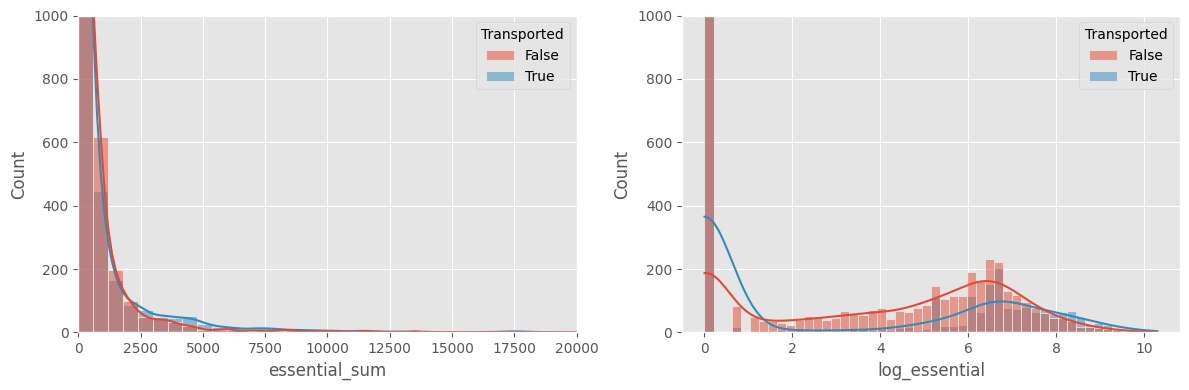

In [35]:
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=pre_train, x='essential_sum', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.histplot(data=pre_train, x='log_essential', hue='Transported', bins=50, kde=True)
plt.ylim([0,1000])
fig.tight_layout()

## Categorical

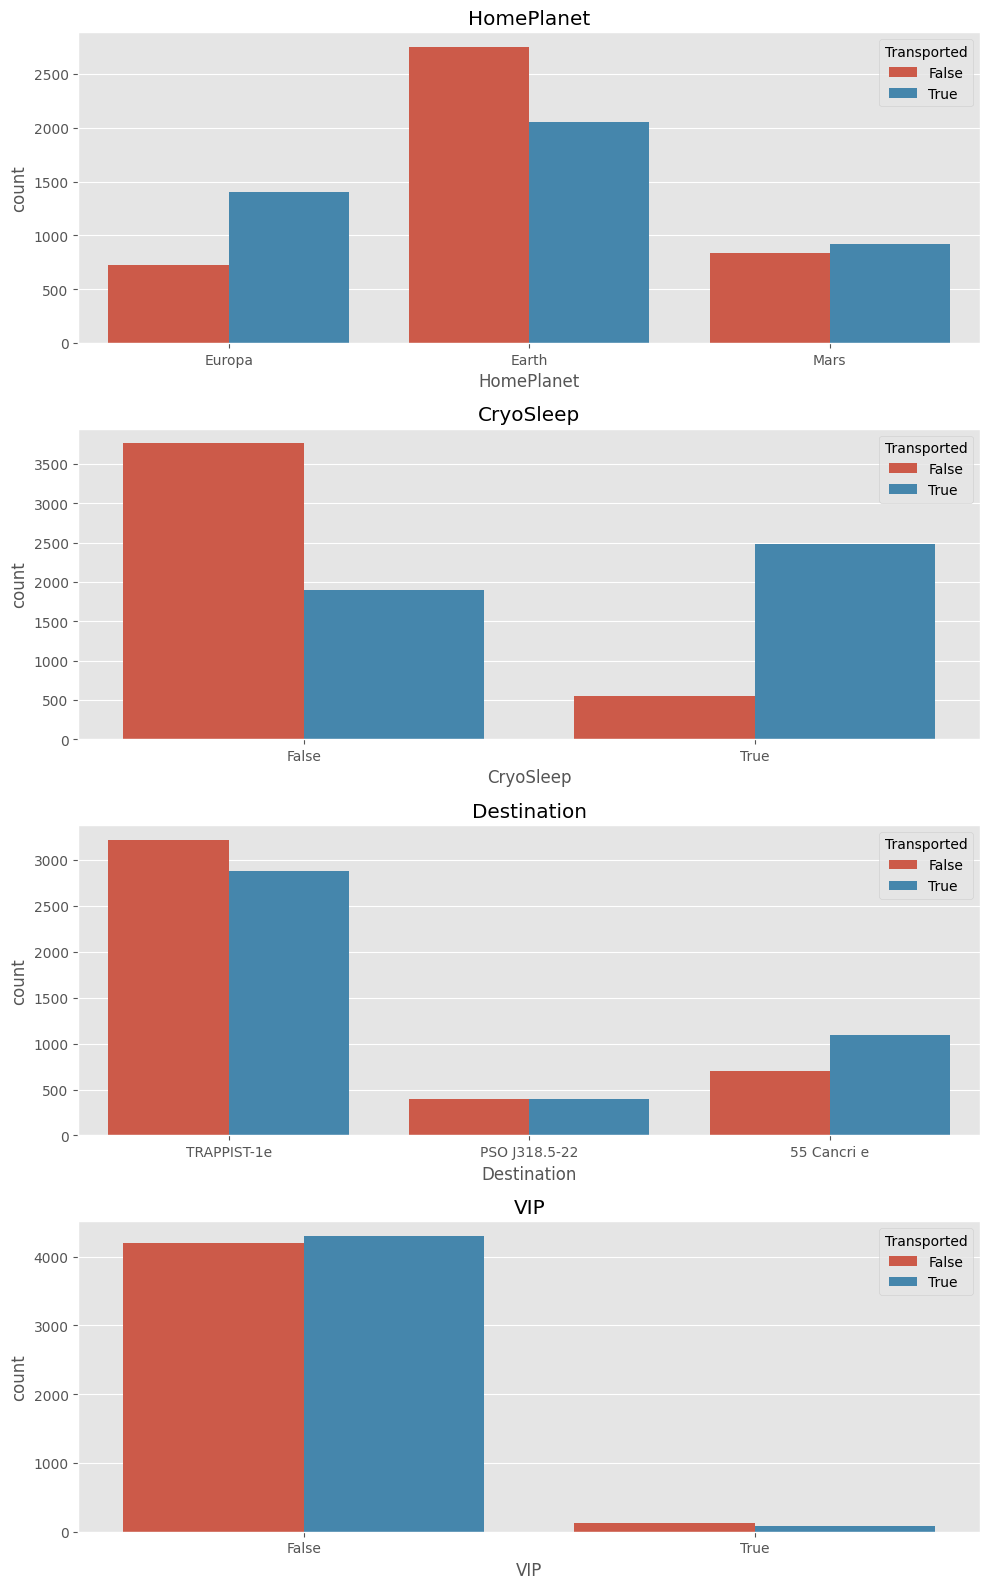

In [36]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=pre_train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

## Text

### PassengerId

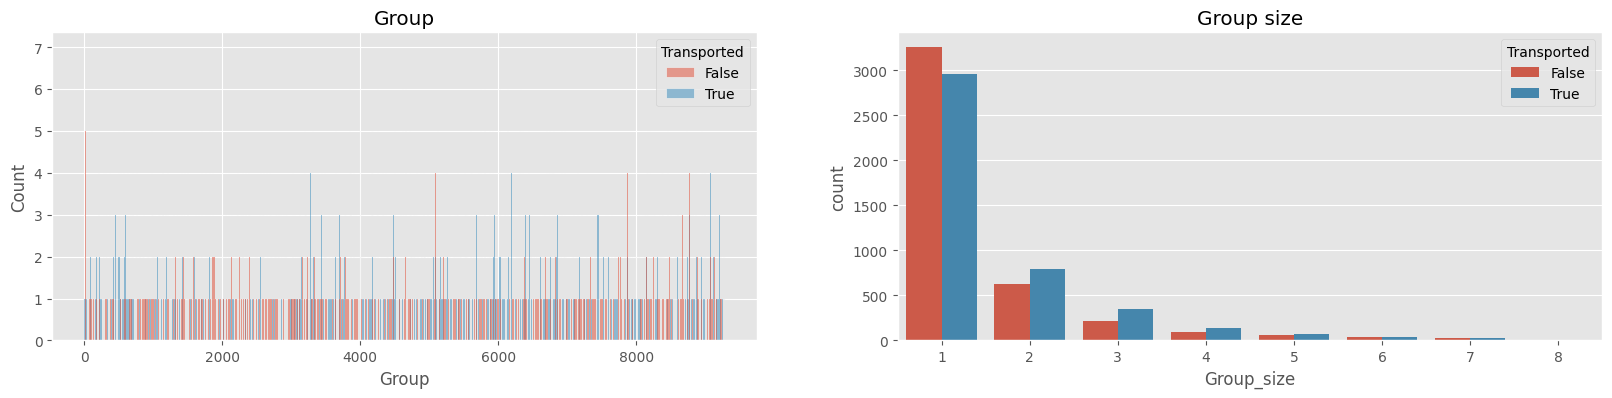

In [37]:
# New feature - Group
pre_train['Group'] = pre_train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
pre_test['Group'] = pre_test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
pre_train['Group_size'] = pre_train['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)
pre_test['Group_size'] = pre_test['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=pre_train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=pre_train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

Text(0.5, 1.0, 'Passenger travelling solo or not')

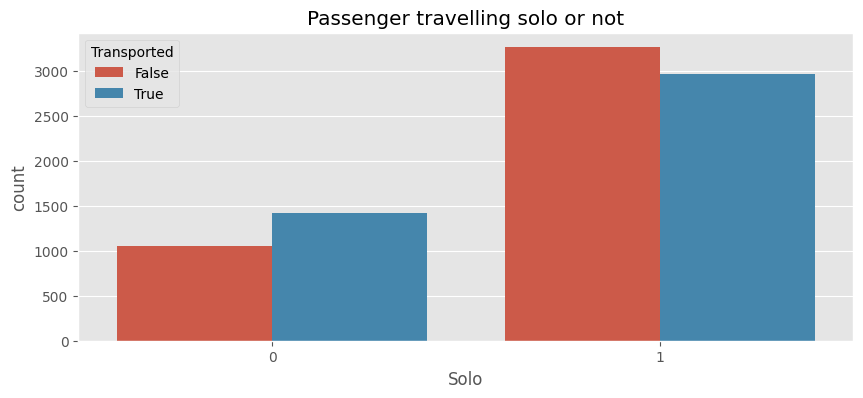

In [38]:
# New feature
pre_train['Solo']=(pre_train['Group_size']==1).astype(int)
pre_test['Solo']=(pre_test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=pre_train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
# plt.ylim([0,3000])

### Name

In [39]:
# New feature - Surname
pre_train['Surname']=pre_train['Name'].str.split().str[-1]
pre_test['Surname']=pre_test['Name'].str.split().str[-1]

pre_train[['Name', 'Surname']].head()

,Name,Surname
0,Maham Ofracculy,Ofracculy
1,Juanna Vines,Vines
2,Altark Susent,Susent
3,Solam Susent,Susent
4,Willy Santantines,Santantines


In [40]:
pre_train['Surname'].value_counts()

Unknown       200
Casonston      18
Oneiles        16
Domington      15
Litthews       15
             ... 
Covale          1
Dun             1
Witalnerod      1
Deryplinet      1
Sionerorly      1
Name: Surname, Length: 2218, dtype: int64

### Cabin

In [41]:
# New features - training set
pre_train['Cabin_deck'] = pre_train['Cabin'].apply(lambda x: x.split('/')[0])
pre_train['Cabin_number'] = pre_train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
pre_train['Cabin_side'] = pre_train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
pre_test['Cabin_deck'] = pre_test['Cabin'].apply(lambda x: x.split('/')[0])
pre_test['Cabin_number'] = pre_test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
pre_test['Cabin_side'] = pre_test['Cabin'].apply(lambda x: x.split('/')[2])

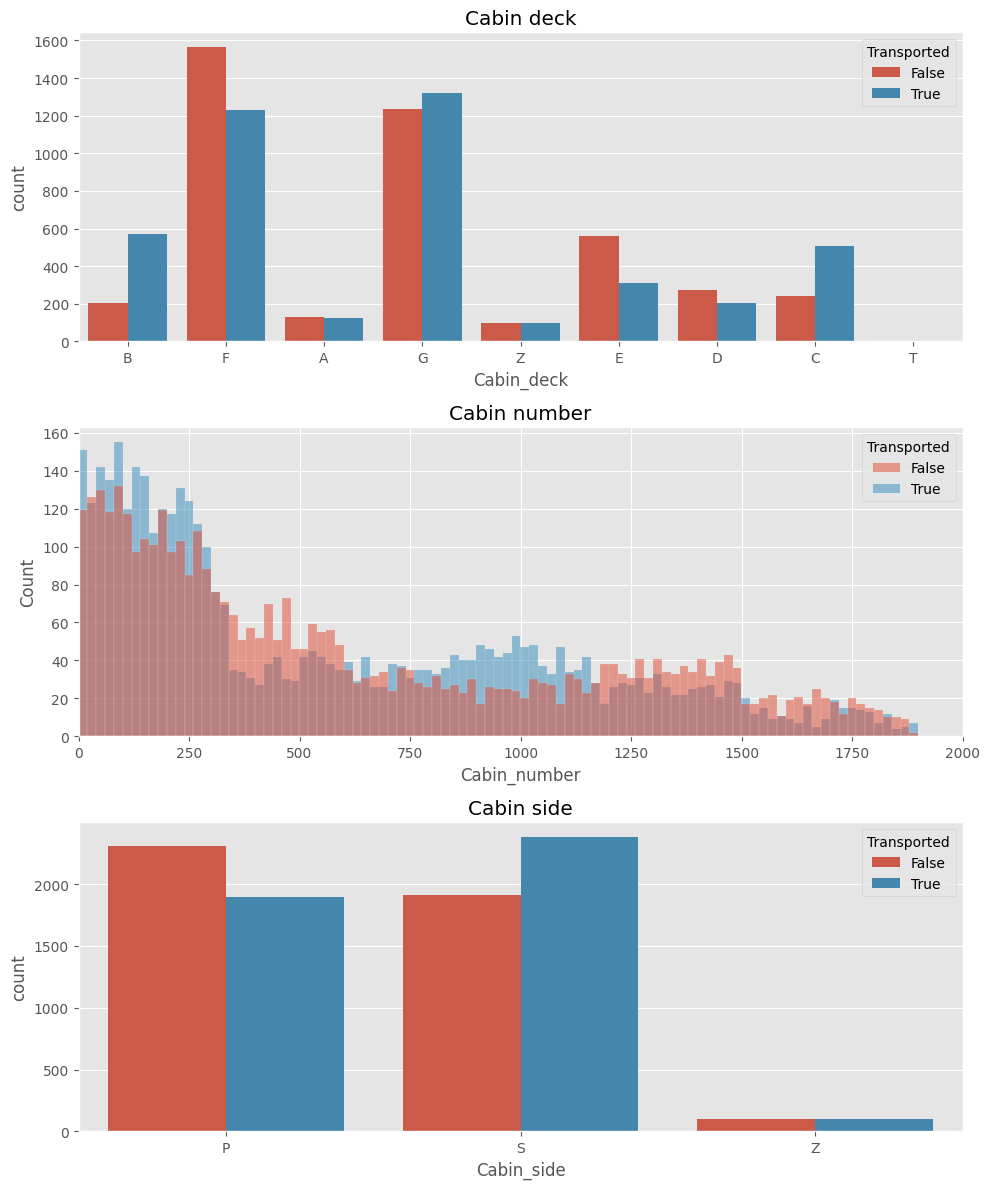

In [42]:
# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)

sns.countplot(data=pre_train, x='Cabin_deck', hue='Transported')
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=pre_train, x='Cabin_number', hue='Transported',bins=500)
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=pre_train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

<Axes: xlabel='Cabin_number', ylabel='Count'>

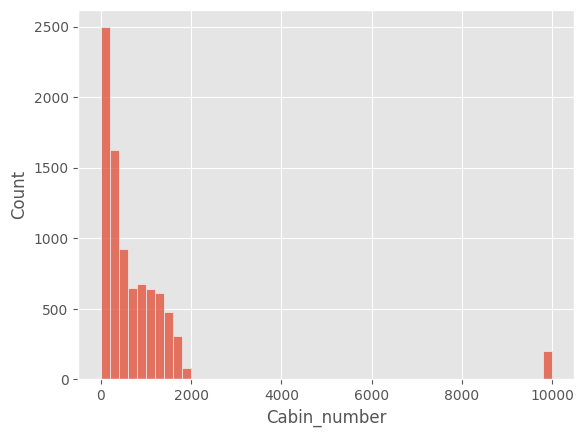

In [43]:
sns.histplot(data=pre_train, x='Cabin_number',bins=50)

In [44]:
pre_train['Cabin_number'].describe()

count    8693.000000
mean      815.520994
std      1494.019017
min         0.000000
25%       173.000000
50%       448.000000
75%      1040.000000
max      9999.000000
Name: Cabin_number, dtype: float64

In [45]:
pre_train['Cabin_number'] = pre_train['Cabin_number'].map(lambda x: np.log1p(x))
pre_test['Cabin_number'] = pre_test['Cabin_number'].map(lambda x: np.log1p(x))

pre_train['Cabin_number'].describe()

count    8693.000000
mean        5.924788
std         1.353201
min         0.000000
25%         5.159055
50%         6.107023
75%         6.947937
max         9.210340
Name: Cabin_number, dtype: float64

<Axes: xlabel='Cabin_number', ylabel='Count'>

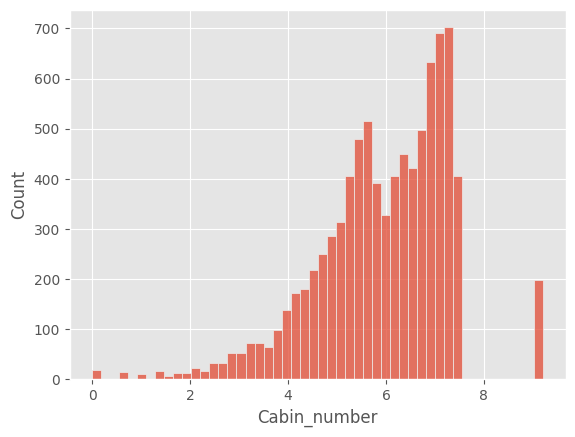

In [46]:
sns.histplot(data=pre_train, x='Cabin_number',bins=50)

## Corr

<Axes: >

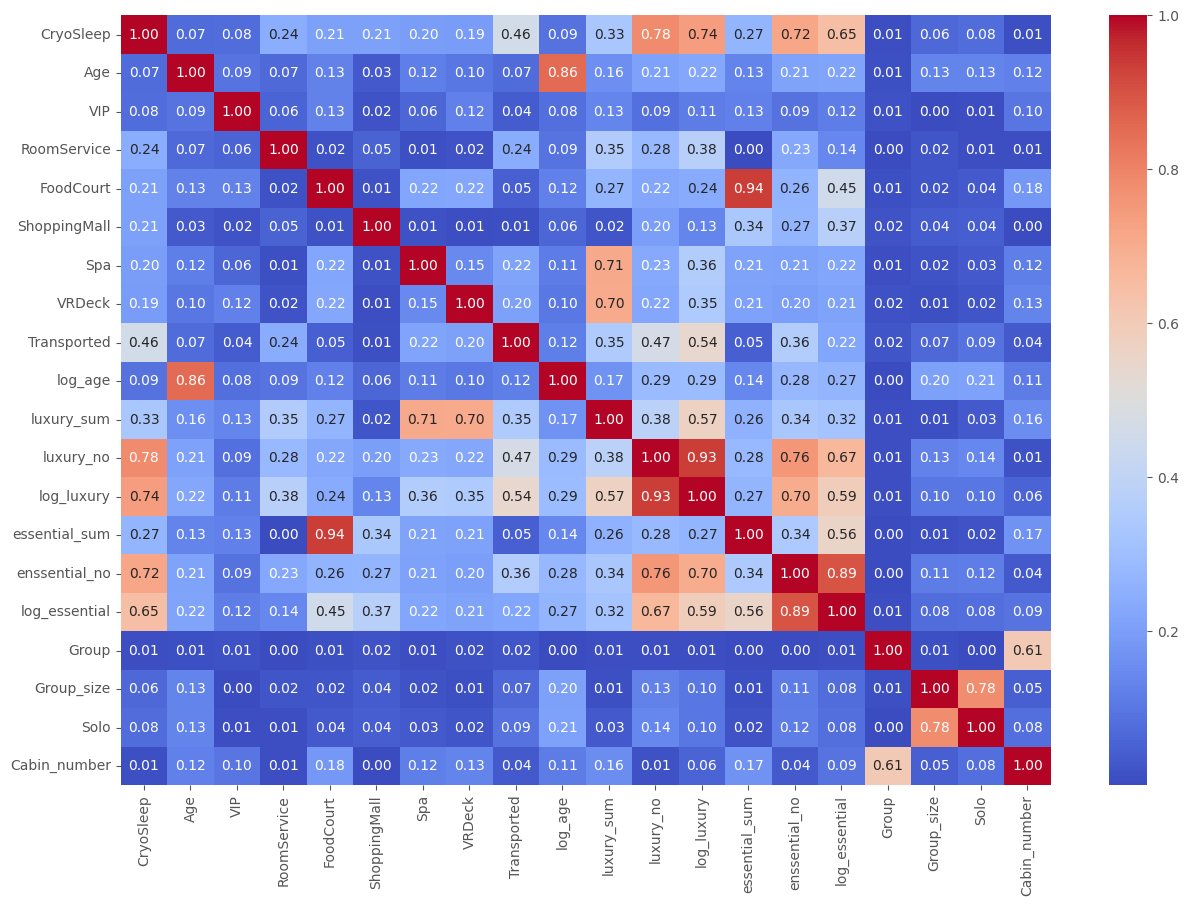

In [47]:
plt.figure(figsize=(15,10))

sns.heatmap(abs(pre_train.corr()), annot=True, fmt=".2f", cmap='coolwarm')

# Feature Selection

In [83]:
fs_train = pre_train.copy()
fs_test = pre_test.copy()

fs_train.shape, fs_test.shape

((8693, 29), (4277, 28))

In [84]:
print(fs_train.shape)
fs_train.head(3)

(8693, 29)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,essential_sum,enssential_no,log_essential,Group,Group_size,Solo,Surname,Cabin_deck,Cabin_number,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,1,0.000000,1,1,1,Ofracculy,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,34.0,0,3.555348,2,1,1,Vines,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,3576.0,0,8.182280,3,1,1,Susent,A,0.0,S


In [85]:
fs_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'age_group', 'log_age', 'luxury_sum',
       'luxury_no', 'log_luxury', 'essential_sum', 'enssential_no',
       'log_essential', 'Group', 'Group_size', 'Solo', 'Surname', 'Cabin_deck',
       'Cabin_number', 'Cabin_side'],
      dtype='object')

## drop columns

In [86]:
drop_cols = ['Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'luxury_sum', 'essential_sum']

In [87]:
fs_train.drop(drop_cols, axis=1, inplace=True)
fs_test.drop(drop_cols, axis=1, inplace=True)

fs_train.shape, fs_test.shape

((8693, 18), (4277, 17))

## convert dtype

In [88]:
fs_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    8693 non-null   object 
 1   HomePlanet     8693 non-null   object 
 2   CryoSleep      8693 non-null   bool   
 3   Destination    8693 non-null   object 
 4   Transported    8693 non-null   bool   
 5   age_group      8693 non-null   object 
 6   log_age        8693 non-null   float64
 7   luxury_no      8693 non-null   int64  
 8   log_luxury     8693 non-null   float64
 9   enssential_no  8693 non-null   int64  
 10  log_essential  8693 non-null   float64
 11  Group          8693 non-null   int64  
 12  Group_size     8693 non-null   int64  
 13  Solo           8693 non-null   int64  
 14  Surname        8693 non-null   object 
 15  Cabin_deck     8693 non-null   object 
 16  Cabin_number   8693 non-null   float64
 17  Cabin_side     8693 non-null   object 
dtypes: bool(

In [89]:
cat_cols = ['HomePlanet', 'Destination', 'age_group', 'Surname', 'Cabin_deck', 'Cabin_side']
for col in cat_cols:
  fs_train[col] = fs_train[col].astype('category')
  fs_test[col] = fs_test[col].astype('category')

In [90]:
fs_train['Transported'] = fs_train['Transported'].astype(int)

In [91]:
fs_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    8693 non-null   object  
 1   HomePlanet     8693 non-null   category
 2   CryoSleep      8693 non-null   bool    
 3   Destination    8693 non-null   category
 4   Transported    8693 non-null   int64   
 5   age_group      8693 non-null   category
 6   log_age        8693 non-null   float64 
 7   luxury_no      8693 non-null   int64   
 8   log_luxury     8693 non-null   float64 
 9   enssential_no  8693 non-null   int64   
 10  log_essential  8693 non-null   float64 
 11  Group          8693 non-null   int64   
 12  Group_size     8693 non-null   int64   
 13  Solo           8693 non-null   int64   
 14  Surname        8693 non-null   category
 15  Cabin_deck     8693 non-null   category
 16  Cabin_number   8693 non-null   float64 
 17  Cabin_side     8693 non-null   ca

# Base Model

In [137]:
print(f'before: {fs_train.shape} / {fs_test.shape}')

train = fs_train.copy()
test = fs_test.copy()

print(f"after: {train.shape} / {test.shape}")
print(f"missing values: {train.isnull().sum().sum()} / {test.isnull().sum().sum()}")
train.head(2)

before: (8693, 18) / (4277, 17)
after: (8693, 18) / (4277, 17)
missing values: 0 / 0


,PassengerId,HomePlanet,CryoSleep,Destination,Transported,age_group,log_age,luxury_no,log_luxury,enssential_no,log_essential,Group,Group_size,Solo,Surname,Cabin_deck,Cabin_number,Cabin_side
0,0001_01,Europa,False,TRAPPIST-1e,0,age_28+,3.688879,1,0.000000,1,0.000000,1,1,1,Ofracculy,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,1,age_27,3.218876,0,6.555357,0,3.555348,2,1,1,Vines,F,0.0,S


## Split data

In [138]:
feature_cols = list(test.columns)
feature_cols.remove('PassengerId')
len(feature_cols)

16

In [139]:
# target
train_target = train['Transported'].values

# features
train_features = train[feature_cols]
test_features = test[feature_cols]

# submission
PassengerId = test['PassengerId'].values

train_features.shape, train_target.shape, test_features.shape, PassengerId.shape

((8693, 16), (8693,), (4277, 16), (4277,))

In [140]:
x_tr, x_te, y_tr, y_te = train_test_split(train_features, train_target, stratify=train_target, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((6519, 16), (2174, 16), (6519,), (2174,))

## Model

In [141]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix

In [142]:
reset_seeds()

base_result_list = []
models = [XGBClassifier(tree_method='hist', enable_categorical=True)
        , LGBMClassifier(verbose= -1)
        , CatBoostClassifier(cat_features=cat_cols, verbose=0)]
model_names = ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

for model_name, _model in list(zip(model_names, models)):
  _model.fit(x_tr, y_tr)
  pred = _model.predict(x_te)

  fpr, tpr, thresholds = roc_curve(y_te, pred)
  base_result_list.append({
      'type':'base',
      'model':model_name,
      'score': _model.score(x_te, y_te),
      'f1_score': f1_score(y_te, pred),
      'auc': auc(fpr, tpr),
      'accuracy_score': accuracy_score(y_te, pred)
  })

## Best Model

In [143]:
df_result = pd.DataFrame(base_result_list).sort_values(by=['auc', 'f1_score'], ascending=False)
df_result

,type,model,score,f1_score,auc,accuracy_score
2,base,CatBoostClassifier,0.809108,0.808314,0.809182,0.809108
1,base,LGBMClassifier,0.800828,0.799444,0.800922,0.800828
0,base,XGBClassifier,0.793008,0.791280,0.793112,0.793008


In [144]:
reset_seeds()

best_model = CatBoostClassifier(cat_features=cat_cols, verbose=0)
best_model.fit(train_features, train_target)

best_pred = best_model.predict(train_features)

### confusion_matrix

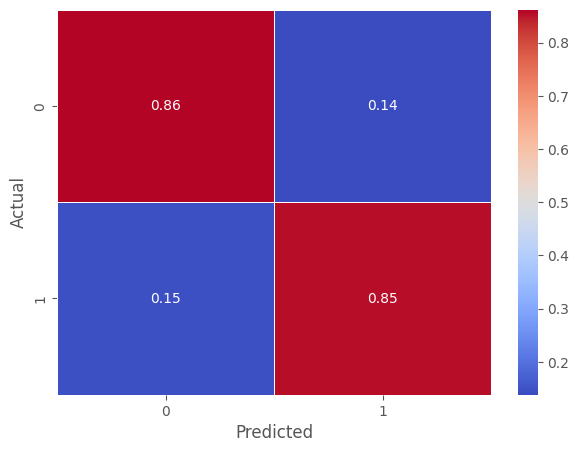

In [145]:
reset_seeds()

norm_conf_mx = confusion_matrix(train_target, best_pred, normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### feature importance

In [146]:
def show_permutation_importance(model, x_te, y_te):
  perm_importance = permutation_importance(model, x_te, y_te, n_repeats=10, random_state=args.SEED)
  sorted_idx = perm_importance.importances_mean.argsort()
  fig = plt.figure(figsize=(12, 6))
  plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
  plt.yticks(range(len(sorted_idx)), np.array(x_te.columns)[sorted_idx])
  plt.title('Permutation Importance')

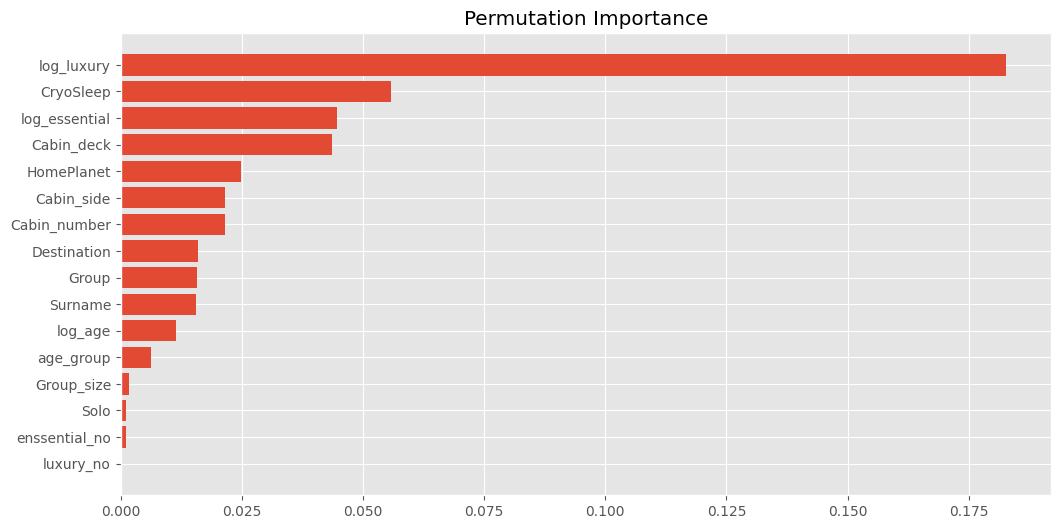

In [147]:
reset_seeds()

show_permutation_importance(best_model, train_features, train_target)

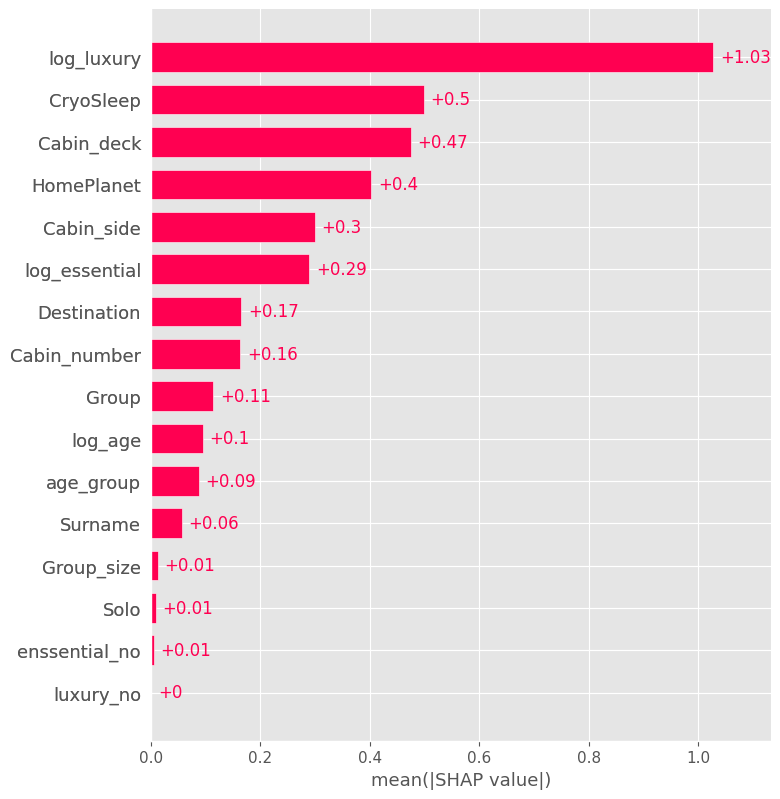

In [148]:
reset_seeds()

explainer = shap.Explainer(best_model)
shap_values = explainer(train_features)
shap.plots.bar(shap_values, max_display=train_features.shape[0])